# Analysis of the robustness of NMF algorithms

## Table of Content

**1.-** Load and Preprocessing Data<br>
**2.-** Utils Functions<br>
**2.1.-** Noise Functions<br>
**2.1.1.-** Salt and Pepper Noise<br>
**2.1.2.-** Gaussian Noise<br>
**2.1.3.-** Laplace Noise<br>
**2.2.-** Metric Functions<br>
**3.-** Non-negative Matrix Factorization<br>
**3.1.-** L1-Norm Regularized Robust NMF<br>
**3.2.-** L2,1-Norm Robust NMF<br>
**3.3.-** L2-Norm MUR NMF<br>
**4.-** Experiments<br>
**4.1.-** Influence of Number of Components<br>
**4.2.-** Influence of Noise Scale<br>
**4.3.-** Performance Comparison<br>
**Appendix**<br>

## Introduction

In this notebook, we examine three non-negative matrix factorization techniques; $L_{2}$-norm, $L_1$ regularized norm, and $L_{2,1}$ norm. Our aim is to establish the performance of these different approaches, and their robustness in real-world applications such as feature selection while managing computational complexity, sensitivity to noise and more. We thoroughly examine each approach from a theoretical perspective, and examine the performance of each using a series of experiments drawing on both the ORL and YaleB datasets. We examine the Relative Reconstruction Errors (RRE), Average Accuracy and Normalized Mutual Information (NMI) as criteria under a range of simulated noise scenarios.

To execute the code you just need to go through the notebook and executing all cells. The first section called ***Load and preprocessing data*** contains the function to load and preprocess the images. In this section, you should add the path to the folder with the datasets, in case you use Google Colab you need to add the datasets to your Drive account and mount your Drive folder into the notebook.

The section ***Utils Functions*** contains functions that are used in the implementation of our algorithms. The functions to generate noise are contained in this section as well as the functions to calculate the metrics. Furthermore, the section called ***Non-negative Matrix Factorization*** contains the implementation of our algorithms and we used the ORL dataset to test them. Finally, the section ***Experiments*** has the experiments we have executed to analyze the performance of the NMF algorithms. Additionally, the section ***Appendix*** contains some images generated for the report.

In [ ]:
import numpy as np
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from scipy import misc
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

## 1.- Load and Preprocessing Data

This section contains the function to load and preprocess the data. The function `load_data` is used to load the data and it applies a scale factor for zooming out the images, in this case we use `reduce=3`. 


**Note:** In this section you need to add the path to the folder with the datasets. Additionally, if you use Google Colab you just need to mount your Drive Folder using the lines above.


In [ ]:
def load_data(root='/content/drive/My\ Drive/comp5328-assignment-1/data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))
            
            # Preprocessing
            # Normalize to the range 0-1
            img = img  / 255.0

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

As we are running the Notebook using Google Colab, we need to mount our drive folder to read the data. If you run the code in your local machine, this line is not necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The datasets used to conduct the experiments are ORL and YaleB. The ORL dataset contains 400 images of 40 distinct subjects. The images were taken varying the lighting, facial expressions and facial details (some subjects wear glasses).  We applied a `reduce constant=3` to load the sample images into vectors with 1100 elements.

On the other hand, YaleB dataset contains 2414 images of 38 subjects under 9 different poses and 64 illumination conditions. We load the sample images, using $\text{reduce constant}=3$, into vectors with 3584 elements.

In this section, we will load the ORL dataset to test and implement all the need functions. However, the experiments, gathered in the `Section Experiments`,  will be performed using both datasets.

In [ ]:
# Reading data - You need to add the path to the folder with the datasets here.
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/ORL", reduce=3)

As we mentioned before, we can observe that the ORL dataset contains 400 images and the images have been loaded into vectors with 1100 elements - `reduce constante = 3`.

In [ ]:
print(f"Shape X: {X.shape}")
print(f"Shape Y: {Y.shape}")

Shape X: (1110, 400)
Shape Y: (400,)


## 2.- Utils Functions

In this section, you will find general functions that will be used in the implementation of the NMF algorithms.

In [ ]:
def array2img(array, w=28, h=28):
    """
    Function to convert an 1D array image into a 2D matrix
    
    :param array: 1D array which we want to convert into a 2D matrix
    :param w: Width image
    :param h: Height image
    """
    return np.asarray(array).reshape(w, h)

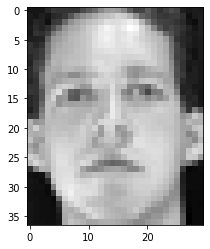

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

test_img = array2img(X[:, 0], 
                     h=img_size[0],
                     w=img_size[1])

plt.imshow(test_img, cmap=plt.cm.gray)

### 2.1.- Noise Functions

Functions implemented to generate and add noise to the original images.

#### 2.1.1.- Salt and Pepper Noise

The noise is generated by randomly change some pixel values in the image. The parameters to tune the salt and pepper noise are *p* and *s_vs_p*. The parameter *p* indicates the noise level, for instance `p=0.1` indicates that the `10%` of the pixel values in the image should be modified. On the other hand, the parameter *s_vs_p* controls the ratio between **Salt and Pepper noise**. For example, if `s_vs_p=0.2`, then `20%` of the modified pixel values should be white.

In [ ]:
def salt_pepper_noise(array_img, p=0.4, s_vs_p=0.3):
  """
  Function to apply salt pepper noise to images.

  For example if p = 0:4, then 40% of the pixel values in a image should
  be modified to either 255 (white) or 0 (black). The parameter s_vs_p controls 
  the ratio of being 255 (white) to the number of modified pixel values. 
  For example, if s_vs_p = 0:3, then 30% of the modified pixel values 
  should be 255 (white).

  :param array_img: Image in 1D array format
  :param p: Percentage of noise
  :param s_vs_p: Percentage of white pixels
  """

  img = np.copy(array_img)

  # Get percentage of noise
  p_noise = int(p*len(img))
  # Percentage of noise with white pixels
  r_white = int(s_vs_p*p_noise)

  noisy_img = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[1]):
    img_i = img[:, i]

    # Noise pixels
    noise_idx = np.random.choice(np.arange(len(img)), 
                                size=p_noise, 
                                replace=False)

    # Salt pixels
    salt_idx = np.random.choice(np.arange(len(noise_idx)), 
                                size=r_white, 
                                replace=False)
    
    salt_noise = np.take(noise_idx, salt_idx)

    # Pepper pixels
    pepper_noise = np.delete(noise_idx, salt_idx)

    # Add noise
    img_i[salt_noise] = 1
    img_i[pepper_noise] = 0

    noisy_img[:, i] = img_i
  return noisy_img

#### 2.1.2.- Gaussian Noise

The **Gaussian Noise**, also known as electronic noise because usually happens in amplifiers or detectors, generates disturbs in the gray values in the digital images. It can be described as below:

\begin{equation}
 \begin{aligned}
    P(g) = \sqrt{\frac{1}{2\pi \sigma^2}}^{-\frac{(g - \mu)^2}{2 \sigma ^2}}
 \end{aligned}
\end{equation}

where $g$ indicates the gray value, $\sigma$ the standard deviation and $\mu$ the mean.

In [ ]:
def gaussian_noise_2d(image, mean=0, sigma=0.05):
  """
  Function to apply gaussian noise to images.
                      
  :param array_img: Image in 2D array format
  :param mean: Zero mean for white noise
  :param sigma: It affects to the -average noise power
  """
  
  return np.clip(image + np.random.normal(mean,sigma,(image.shape)), 0, 1)


#### 2.1.3.- Laplace Noise 

Laplace Noise is generated by the **Laplace Distribution** and it is pretty similar to the Gaussian Distribution although it has a sharper peak around the mean value. The Laplace Distribution can be described as below:

\begin{equation}
 \begin{aligned}
    f(x|\mu, \lambda) = \frac{1}{2\lambda}\exp(-\frac{|x - \mu|}{\lambda}) = \frac{1}{2\lambda} \begin{cases}
      \exp(-\frac{\mu - x}{\lambda}) & \text{if $x < \mu$}\\
      \exp(-\frac{x - \mu}{\lambda}) & \text{if $x \geq \mu$}
    \end{cases}    
 \end{aligned}
\end{equation}

where $\mu$ denotes the mean value and $\lambda$ is a scale parameter.

In [ ]:
def laplace_noise(image, loc=0, scale=0.05):
  """
  Function to apply laplacian noise to images.

  :param array_img: Image in 2D array format
  :param loc: The position, \mu, of the distribution peak
  :param scale: \lambda, the exponential decay. Default is 1. Must be non- negative.
  """
  return np.clip(image + np.random.laplace(loc, scale, image.shape), 0, 1)


In the next cell, we are presenting an example image with the different types of noise implemented before.

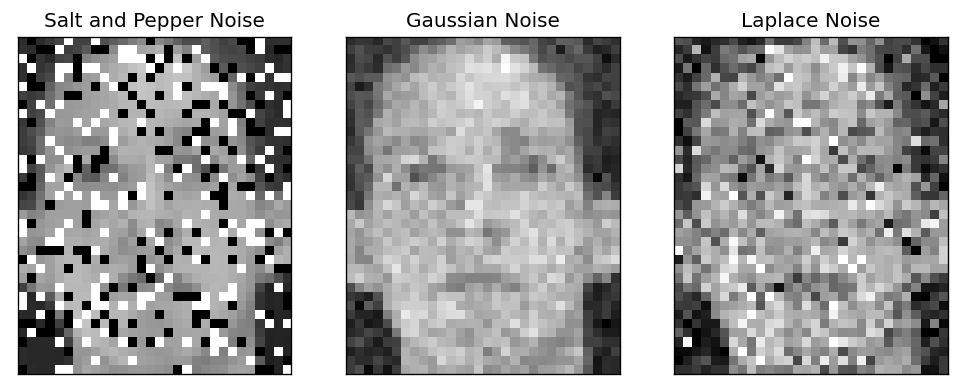

In [ ]:
# Example noise
plt.figure(figsize=(10,10), dpi=120)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
      
    if i == 0:
      X_noisy = salt_pepper_noise(X, p=0.3, s_vs_p=0.5)
      title = "Salt and Pepper Noise"
    elif i == 1:
      X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)
      title = "Gaussian Noise"
    else:
      X_noisy = laplace_noise(X, loc=0, scale=0.11)
      title = "Laplace Noise"

    test_img_noise = array2img(X_noisy[:, 0], 
                               h=img_size[0],
                               w=img_size[1])

    # Set title
    plt.title(f'{title}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

### 2.2.- Metric Functions

This section contains the needed functions to calculate the different metrics. We implement and use three evaluation metrics:

- **Relative  Reconstruction  Errors  (RRE)**

  \begin{equation}
    RRE=\frac{\|\widehat{X} - UV\|_F}{\|\widehat{X}\|_F}
  \end{equation}

- **Average Accuracy**

  \begin{equation}
    ACC(Y, Y_{pred})=\frac{1}{n}\sum\limits_{i=1}^n1\{Y_{pred}(i) == Y(i)\}
  \end{equation}

- **Normalized Mutual Information (NMI)**

  \begin{equation}
    NMI(Y, Y_{pred})=\frac{2 \ast I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}
  \end{equation}

In [ ]:
def assign_cluster_label(X, Y):
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

def rre(X_true, X_rec):
  """
  Function to compute reconstruction error.

  :param X_true: Original X
  :param X_rec: Reconstructed Data - X_hat
  """
  return np.linalg.norm(X_true - X_rec, ord="fro") / np.linalg.norm(X_true)

def accuracy(Y_true, Y_pred):
  """
  Function to compute accuracy.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return Accuracy
  """
  return accuracy_score(Y_true, Y_pred)

def nmi_score(Y_true, Y_pred):
  """
  Function to compute Normalized Mutual Information metric.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return NMI
  """
  return normalized_mutual_info_score(Y_true, Y_pred)

def evaluate(X, X_rec, Y_true, H):
  """
  Function to compute RRE, Average Accuracy and NMI.

  :param X: Original X
  :param X_rec: Reconstructed X
  :param Y_true: Original Y
  :param H: V matrix
  :return RRE, acc, NMI
  """
  Y_pred = assign_cluster_label(H.T, Y_true)
  rre_metric = rre(X, X_rec)
  acc_metric = accuracy(Y_true, Y_pred)
  nmi_metric = nmi_score(Y_true, Y_pred)
  return rre_metric, acc_metric, nmi_metric

## 3.- Non-negative Matrix Factorization

In this section, we present the implementation of the 3 different Non-negative Matrix Factorization algorithms. A detailed formulation of each one are provided in the report.

### 3.1.- L1-Norm Regularized Robust NMF


In [ ]:
class L1regNMF():
  def __init__(self,):
    pass

  def _initialize_matrices(self,):
    """
    Function to initialize U, V and E matrices using norm distribution with
    mean 0 and variance 1
    """
    
    # Set seed
    np.random.seed(self.seed)

    # Using random normal to initialize U, V, E
    U = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.m, self.k)))
    V = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.k, self.n)))
    E = np.abs(np.random.normal(loc=0.0, scale=1, size=(self.m, self.n)))
    return U, V, E

  def _compute(self,):
    """
    Function to compute 
    """

    # Initialize U, V, E
    U, V, E = self._initialize_matrices()

    rre_metric = []
    acc_metric = []
    nmi_metric = []
    for _ in range(self.n_iter):
      X_hat = self.X_noisy - E
      Ep = 0.5*(np.abs(E) + E)
      En = 0.5*(np.abs(E) - E)

      # Update U
      U = U * ((X_hat.dot(V.T)) / U.dot(V.dot(V.T)))
      
      # Update V, Ep, En
      V_hat = np.vstack((V, Ep, En))
      X_hat = np.vstack((self.X_noisy, np.zeros(self.n)))
     
      # Identity matrix
      Id = np.eye(self.m)
      U_hat = np.hstack((U, Id, -Id))

      # Create regularization array
      zero_array = np.zeros((1, self.k))
      reg_array = np.full((1, self.m), np.sqrt(self.reg_param) * np.exp(1))
      
      U_hat = np.vstack((U_hat, np.hstack((zero_array, reg_array, reg_array))))
      SV_hat = np.abs(U_hat.T.dot(U_hat.dot(V_hat)))

      aux = ((U_hat.T.dot(U_hat.dot(V_hat))) - (U_hat.T.dot(X_hat))) / SV_hat
      V_hat = np.maximum(0, V_hat - V_hat * aux)

      # Update V, Ep, En and E
      V = V_hat[0:self.k,:]
      E_p = V_hat[self.k:self.k+self.m,:]
      E_n = V_hat[self.k+self.m:,:]
      E = E_p - E_n

      # Print loss
      if _ % 5 == 0:
        # Calculate Metrics
        rre_vle, acc_vle, nmi_vle = evaluate(self.X, 
                                             self.reconstruct_data(U, V, E), 
                                             self.Y, 
                                             V)
        #loss_vla = rre(X, self.reconstruct_data(U, V, E))
        rre_metric.append((_, round(rre_vle, 3)))
        acc_metric.append((_, round(acc_vle, 3)))
        nmi_metric.append((_, round(nmi_vle, 3)))
        print(f"Iteration: {_} - Error: {round(rre_vle, 3)} - Acc: {round(acc_vle, 3)} - NMI: {round(nmi_vle, 3)}")
    return U, V, E, rre_metric, acc_metric, nmi_metric

  def reconstruct_data(self, U, V, E):
    """
    Function to reconstruct data from U, V, E

    :param U: U matrix
    :param V: V matrix
    :param E: E matrix
    :return X_hat: Reconstructed Data
    """
    return U.dot(V) - E

  def fit(self, X, 
          X_noisy, 
          Y,
          n_components, 
          n_iter, 
          regularization_param=0.05, 
          seed=42, 
          plot=True):
    """
    Function to computer the U, V and E matrices

    :param X: Original Data - For calculating metrics
    :param X_noisy: Data with noisy
    :param Y: Original Label - For calculating metrics
    :param n_components: Number of components
    :param n_iter: Number of iterations
    :param regularization_param: Value of the regularization parameter
    :param seed: Seed
    :param plot: To plot the loss
    :return U, V, E Matrices
    """

    # Initialize data
    self.X = X
    self.X_noisy = X_noisy
    self.Y = Y
    self.m, self.n = X.shape
    self.k = n_components
    self.reg_param = regularization_param
    self.n_iter = n_iter
    self.seed = seed

    U, V, E, rre_metric, acc_metric, nmi_metric = self._compute()

    if plot:
      fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
      axs[0].plot([el[0] for el in rre_metric], [el[1] for el in rre_metric])
      axs[1].plot([el[0] for el in acc_metric], [el[1] for el in acc_metric])
      axs[2].plot([el[0] for el in nmi_metric], [el[1] for el in nmi_metric])
      axs[0].set_title('Reconstruction Error')
      axs[0].set_xlabel('Iterations')
      axs[0].set_ylabel('RRE')

      axs[1].set_title('Acccuracy')
      axs[1].set_xlabel('Iterations')
      axs[1].set_ylabel('ACC')

      axs[2].set_title('Normalized Mutual Information')
      axs[2].set_xlabel('Iterations')
      axs[2].set_ylabel('NMI')
      fig.tight_layout()
    return U, V, E

We test that our implementation runs correctly using the ORL dataset previously loaded.

Iteration: 0 - Error: 1.665 - Acc: 0.172 - NMI: 0.32
Iteration: 5 - Error: 0.292 - Acc: 0.18 - NMI: 0.35
Iteration: 10 - Error: 0.289 - Acc: 0.188 - NMI: 0.352
Iteration: 15 - Error: 0.285 - Acc: 0.198 - NMI: 0.371
Iteration: 20 - Error: 0.277 - Acc: 0.228 - NMI: 0.4
Iteration: 25 - Error: 0.264 - Acc: 0.275 - NMI: 0.46
Iteration: 30 - Error: 0.25 - Acc: 0.315 - NMI: 0.523
Iteration: 35 - Error: 0.237 - Acc: 0.375 - NMI: 0.583


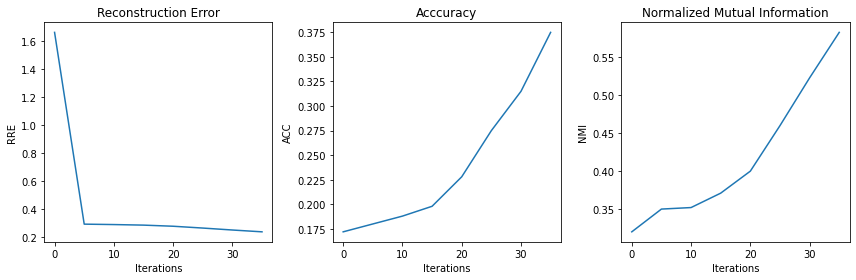

In [ ]:
# Adding gaussian noise to the original dataset
X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)

# Initialize algorithm
L1reg = L1regNMF()

# Run it
U, V, E = L1reg.fit(X=X, 
                    X_noisy=X_noisy, 
                    Y=Y, 
                    n_components=40, 
                    n_iter=40)

# Reconstruct image
X_hat = L1reg.reconstruct_data(U, V, E)

In [ ]:
rre_metric, acc_metric, nmi_metric = evaluate(X=X, X_rec=X_hat, Y_true=Y, H=V)

print(f"Reconstruction Error: {rre_metric}")
print(f"Accuracy: {acc_metric}")
print(f"Normalized mutual information: {nmi_metric}")

Reconstruction Error: 0.2278048942261485
Accuracy: 0.4275
Normalized mutual information: 0.6210390000749618


Displaying the `original image`, `noisy image`, `basis image` and the `reconstructed image`.

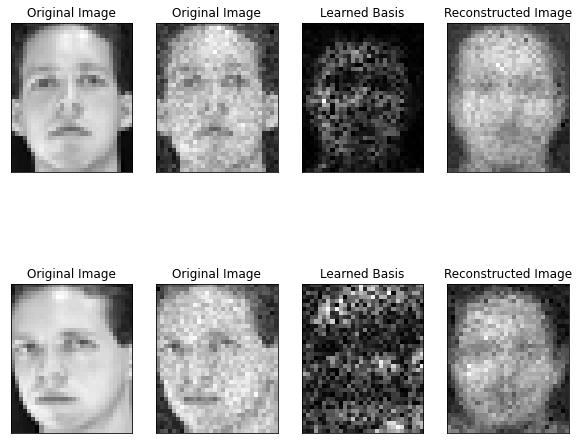

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

n_imgs = 2

fig, axs = plt.subplots(nrows=n_imgs, ncols=4, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
for n in range(n_imgs):
    # Plot original data
    org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
    axs[n,0].imshow(org_data, cmap=plt.cm.gray)
    axs[n,0].set_xticks([])
    axs[n,0].set_yticks([])
    axs[n,0].set_title('Original Image')

    # Plot noisy image
    org_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
    axs[n,1].imshow(org_data, cmap=plt.cm.gray)
    axs[n,1].set_xticks([])
    axs[n,1].set_yticks([])
    axs[n,1].set_title('Original Image')

    # Plot basis image
    rest_data = array2img(U[:, n], h=img_size[0], w=img_size[1])
    axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,2].set_xticks([])
    axs[n,2].set_yticks([])
    axs[n,2].set_title('Learned Basis')

    # Plot reconstructed image
    rest_data = array2img(X_hat[:, n], h=img_size[0], w=img_size[1])
    axs[n,3].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,3].set_xticks([])
    axs[n,3].set_yticks([])
    axs[n,3].set_title('Reconstructed Image')

### 3.2.- L2,1-Norm Robust NMF

In [ ]:
class L21normNMF():
  def __init__(self,):
    pass

  def _initialize_matrices(self, X):
    """
    Function to initialize U, V and E matrices using random assignment
    """

    # Set seed
    rng = np.random.RandomState(self.seed)

    U = np.abs(np.random.normal(loc=127, scale=4, size=(self.m, self.k)))
    V = np.abs(np.random.normal(loc=127, scale=4, size=(self.k, self.n)))

    return U, V

  def _compute(self, X):

    U,V = self._initialize_matrices(X)
    tol=1e-5

    rre_metric = []
    acc_metric = []
    nmi_metric = []

    for step in range(self.n_iter):

      D = np.diag(1 / np.sqrt(np.sum(np.square(X - U.dot(V)), axis=0)))

      Uu = U * (X.dot(D).dot(V.T))/(U.dot(V).dot(D).dot(V.T)+1e-10)
      Vu = V * (Uu.T.dot(X).dot(D))/(Uu.T.dot(Uu).dot(V).dot(D)+1e-10)
      
      if step % 5 == 0:
        rre_vle, acc_vle, nmi_vle = evaluate(self.X, self.reconstruct_data(Uu, Vu), self.Y, Vu)
        print(f"Iteration: {step} - Error: {round(rre_vle, 3)} - Acc: {round(acc_vle, 3)} - NMI: {round(nmi_vle, 3)}")
        rre_metric.append((step, round(rre_vle, 3)))
        acc_metric.append((step, round(acc_vle, 3)))
        nmi_metric.append((step, round(nmi_vle, 3)))

      e_U = np.sqrt(np.sum((Uu-U)**2, axis=(0,1)))/U.size
      e_V = np.sqrt(np.sum((Vu-V)**2, axis=(0,1)))/V.size

      if e_U<tol and e_V<tol:
        print("step is:",step)
        break

      U = Uu
      V = Vu

    return U, V, rre_metric, acc_metric, nmi_metric

  def fit(self, X, 
          X_noisy,
          Y,
          n_components, 
          n_iter=5000,
          seed=42, 
          plot=True):
    """
    Function to computer the U, V and E matrices

    :param X: Original Data - For calculating metrics
    :param X_noisy: Data with noise
    :param Y: Original Label - For calculating metrics
    :param n_components: Number of components
    :param n_iter: Number of iterations
    :param seed: Seed
    :param plot: To plot the loss
    :return U, V, E Matrices
    """

    # Initialize data
    self.X = X
    self.Y = Y
    self.m, self.n = X.shape
    self.k = n_components
    self.n_iter = n_iter
    self.seed = seed

    U, V, rre_metric, acc_metric, nmi_metric = self._compute(X_noisy)
    
    if plot:
      fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
      axs[0].plot([el[0] for el in rre_metric], [el[1] for el in rre_metric])
      axs[1].plot([el[0] for el in acc_metric], [el[1] for el in acc_metric])
      axs[2].plot([el[0] for el in nmi_metric], [el[1] for el in nmi_metric])
      axs[0].set_title('Reconstruction Error')
      axs[0].set_xlabel('Iterations')
      axs[0].set_ylabel('RRE')

      axs[1].set_title('Acccuracy')
      axs[1].set_xlabel('Iterations')
      axs[1].set_ylabel('ACC')

      axs[2].set_title('Normalized Mutual Information')
      axs[2].set_xlabel('Iterations')
      axs[2].set_ylabel('NMI')
      fig.tight_layout()
    return U, V

  def reconstruct_data(self, U, V):
    """
    Function to reconstruct data from U, V

    :param U: U matrix
    :param V: V matrix
    :return X_hat: Reconstructed Data
    """
    return U.dot(V)

As we did previously, we test our implementation using the ORL dataset.

Iteration: 0 - Error: 0.286 - Acc: 0.27 - NMI: 0.474
Iteration: 5 - Error: 0.283 - Acc: 0.272 - NMI: 0.499
Iteration: 10 - Error: 0.283 - Acc: 0.265 - NMI: 0.472
Iteration: 15 - Error: 0.283 - Acc: 0.292 - NMI: 0.522


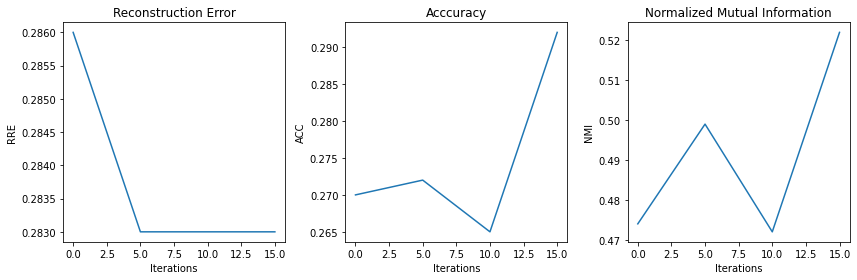

In [ ]:
# Adding gaussian noise to the original dataset
X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)

# Initialize algorithm
l21norm = L21normNMF()

# Run it
U, V = l21norm.fit(X=X, 
                   X_noisy=X_noisy, 
                   Y=Y, 
                   n_components=40, 
                   n_iter=20)

# Reconstruct image
X_hat = l21norm.reconstruct_data(U, V)

In [ ]:
rre_metric, acc_metric, nmi_metric = evaluate(X=X, X_rec=X_hat, Y_true=Y, H=V)

print(f"Reconstruction Error: {rre_metric}")
print(f"Accuracy: {acc_metric}")
print(f"Normalized mutual information: {nmi_metric}")

Reconstruction Error: 0.282504721891859
Accuracy: 0.345
Normalized mutual information: 0.5483948666696205


Displaying the `original image`, `noisy image`, `basis image` and the `reconstructed image`.

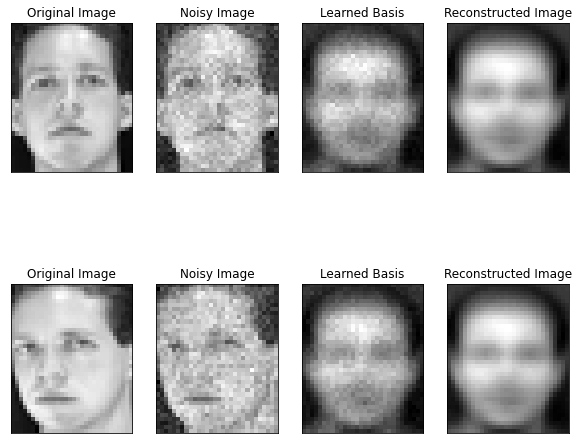

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

n_imgs = 2

fig, axs = plt.subplots(nrows=n_imgs, ncols=4, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
for n in range(n_imgs):
    # Plot original data
    org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
    axs[n,0].imshow(org_data, cmap=plt.cm.gray)
    axs[n,0].set_xticks([])
    axs[n,0].set_yticks([])
    axs[n,0].set_title('Original Image')

    # Plot noisy image
    org_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
    axs[n,1].imshow(org_data, cmap=plt.cm.gray)
    axs[n,1].set_xticks([])
    axs[n,1].set_yticks([])
    axs[n,1].set_title('Noisy Image')

    # Plot basis image
    rest_data = array2img(U[:, n], h=img_size[0], w=img_size[1])
    axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,2].set_xticks([])
    axs[n,2].set_yticks([])
    axs[n,2].set_title('Learned Basis')

    # Plot reconstructed image
    rest_data = array2img(X_hat[:, n], h=img_size[0], w=img_size[1])
    axs[n,3].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,3].set_xticks([])
    axs[n,3].set_yticks([])
    axs[n,3].set_title('Reconstructed Image')

### 3.3.- L2-Norm MUR NMF


In [ ]:
class L2NMF():
  def __init__(self):
      pass

  def reconstruct_data(self, W, H):
      """
      Function to reconstruct data from W. H

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      return W.dot(H)

  def SVDbased_init(self, X, rank):
      """
      Function SVD based initiation

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      u,s,v=np.linalg.svd(X,full_matrices=False)
      v=v.T
      w=np.zeros((X.shape[0],rank))
      h=np.zeros((rank,X.shape[1]))

      w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
      h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

      for i in range(1,rank):
          
          ui=u[:,i]
          vi=v[:,i]
          ui_pos=(ui>=0)*ui
          ui_neg=(ui<0)*-ui
          vi_pos=(vi>=0)*vi
          vi_neg=(vi<0)*-vi
          
          ui_pos_norm=np.linalg.norm(ui_pos,2)
          ui_neg_norm=np.linalg.norm(ui_neg,2)
          vi_pos_norm=np.linalg.norm(vi_pos,2)
          vi_neg_norm=np.linalg.norm(vi_neg,2)
          
          norm_pos=ui_pos_norm*vi_pos_norm
          norm_neg=ui_neg_norm*vi_neg_norm
          
          if norm_pos>=norm_neg:
              w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
              h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
          else:
              w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
              h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T
      return w, h

  def random_init(self, X, rank):
      """
      Function to initiate randomly

      :param X: input matrix
      :param rank: components

      """
      number_of_features = X.shape[0]
      number_of_observations = X.shape[1]

      W = np.random.uniform(1,2,(number_of_features,self.rank))
      H = np.random.uniform(1,2,(self.rank,number_of_observations))
      return W, H

  # L2 Multiplicative NMF
  def compute(self, X):
      
      """
      Function to NMF X ~ WH

      :param X: input matrix (feats x samples)
      :param k: number of component/rank
      :param n_inter: number of interation
      
      """     
      W, H = self.SVDbased_init(X, self.rank)
     #W, H = self.random_init(X, self.rank)
      k = self.rank
      e = 1.0e-10
      
      norms = []
      rre_metric = []
      acc_metric = []
      nmi_metric = []

      for n in range(self.n_iter):
          # Update H
          W_TX = W.T@X
          W_TWH = W.T@W@H+e
          for i in range(np.size(H, 0)):
              for j in range(np.size(H, 1)):
                  H[i, j] = H[i, j] * W_TX[i, j] / W_TWH[i, j]
          # Update W
          XH_T = X@H.T
          WHH_T =  W@H@H.T+ e

          for i in range(np.size(W, 0)):
              for j in range(np.size(W, 1)):
                  W[i, j] = W[i, j] * XH_T[i, j] / WHH_T[i, j]

          norm = np.linalg.norm(X - W@H, 'fro')
          norms.append(norm)
      
          # Print loss
          if n % 5 == 0:
            # Calculate Metrics
            rre_vle, acc_vle, nmi_vle = evaluate(self.X, self.reconstruct_data(W, H), 
                                                self.Y, H)
            #loss_vla = rre(X, self.reconstruct_data(U, V, E))
            rre_metric.append((n, round(rre_vle, 3)))
            acc_metric.append((n, round(acc_vle, 3)))
            nmi_metric.append((n, round(nmi_vle, 3)))
            print(f"Iteration: {n} - Error: {round(rre_vle, 3)} - Acc: {round(acc_vle, 3)} - NMI: {round(nmi_vle, 3)}")
      return W, H, rre_metric, acc_metric, nmi_metric

  def fit(self, X, X_noisy, Y, n_components,
          n_iter, 
          plot=True):
      """
      Function to compute W H

      :param X: Data
      :param X: Data with added noise
      :param Y: True label
      :param n_components: Number of components
      :param n_iter: Number of iterations
      :param plot: To plot the loss
      :return W, H Matrices
      """

      # Initialize data
      self.X = X
      self.X_noisy = X_noisy
      self.Y = Y
      self.n_iter = n_iter
      self.rank = n_components

      W, H, rre_metric, acc_metric, nmi_metric = self.compute(X_noisy)

      if plot:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
        axs[0].plot([el[0] for el in rre_metric], [el[1] for el in rre_metric])
        axs[1].plot([el[0] for el in acc_metric], [el[1] for el in acc_metric])
        axs[2].plot([el[0] for el in nmi_metric], [el[1] for el in nmi_metric])
        axs[0].set_title('Reconstruction Error')
        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('RRE')

        axs[1].set_title('Acccuracy')
        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('ACC')

        axs[2].set_title('Normalized Mutual Information')
        axs[2].set_xlabel('Iterations')
        axs[2].set_ylabel('NMI')
        fig.tight_layout()
      return W, H

Testing our implementation using the ORL dataset.

Iteration: 0 - Error: 0.23 - Acc: 0.69 - NMI: 0.821
Iteration: 5 - Error: 0.21 - Acc: 0.69 - NMI: 0.823
Iteration: 10 - Error: 0.201 - Acc: 0.69 - NMI: 0.817
Iteration: 15 - Error: 0.195 - Acc: 0.692 - NMI: 0.824
Iteration: 20 - Error: 0.19 - Acc: 0.682 - NMI: 0.814
Iteration: 25 - Error: 0.187 - Acc: 0.702 - NMI: 0.826
Iteration: 30 - Error: 0.185 - Acc: 0.68 - NMI: 0.825
Iteration: 35 - Error: 0.183 - Acc: 0.715 - NMI: 0.838


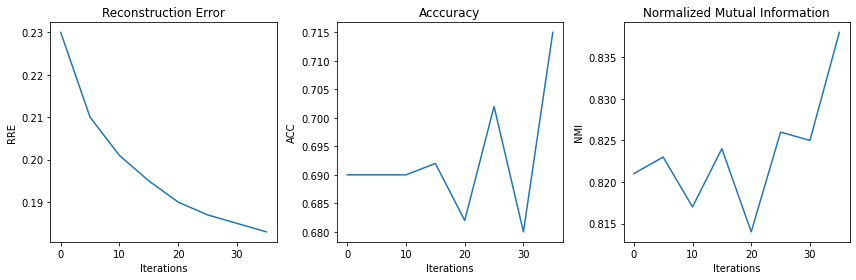

In [ ]:
# Add noise to original images
X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)

# Initialize algorithm
L2MUR = L2NMF()

# Run it
W, H = L2MUR.fit(X=X, 
                 X_noisy=X_noisy, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40)

# Reconstruct image
X_hat = L2MUR.reconstruct_data(W, H)

In [ ]:
rre_metric, acc_metric, nmi_metric = evaluate(X=X, X_rec=X_hat, Y_true=Y, H=H)

print(f"Reconstruction Error: {rre_metric}")
print(f"Accuracy: {acc_metric}")
print(f"Normalized mutual information: {nmi_metric}")

Reconstruction Error: 0.18119609418239238
Accuracy: 0.725
Normalized mutual information: 0.8342833113443966


Plotting the original, basis and reconstructed image.

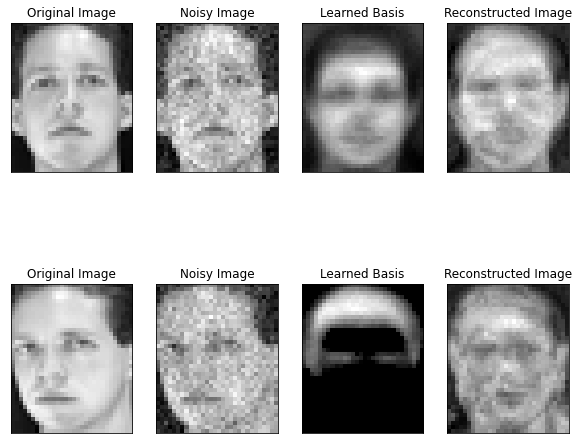

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

n_imgs = 2

fig, axs = plt.subplots(nrows=n_imgs, ncols=4, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
for n in range(n_imgs):
    # Plot original data
    org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
    axs[n,0].imshow(org_data, cmap=plt.cm.gray)
    axs[n,0].set_xticks([])
    axs[n,0].set_yticks([])
    axs[n,0].set_title('Original Image')

    # Plot noisy image
    org_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
    axs[n,1].imshow(org_data, cmap=plt.cm.gray)
    axs[n,1].set_xticks([])
    axs[n,1].set_yticks([])
    axs[n,1].set_title('Noisy Image')

    # Plot basis image
    rest_data = array2img(W[:, n], h=img_size[0], w=img_size[1])
    axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,2].set_xticks([])
    axs[n,2].set_yticks([])
    axs[n,2].set_title('Learned Basis')

    # Plot reconstructed image
    rest_data = array2img(X_hat[:, n], h=img_size[0], w=img_size[1])
    axs[n,3].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,3].set_xticks([])
    axs[n,3].set_yticks([])
    axs[n,3].set_title('Reconstructed Image')

## 4.- Experiments

This section contains the experiments performed using the different algorithms implemented before. In this case, we will use the ORL and YaleB datasets and we will measure the performance and robustness of each algorithm.

In [ ]:
def load_data(root, reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # Normalize to the range 0-1
            img = img  / 255.0

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [ ]:
def random_sample(X, y, size=0.9):
  """
  Function to randomly sampling data from X

  :param X: X data
  :param y: y data
  :param size: Percentage
  """

  # Get index
  idx = np.arange(X.shape[1])
  # Randomly shuffle idx
  np.random.shuffle(idx)
  # Get data
  idx_rand = idx[0:int(len(idx)*size)]

  X_sample, y_sample = X[:, idx_rand], y[idx_rand]
  return X_sample, y_sample

In [ ]:
def assign_cluster_label(X, Y):
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

def rre(X_true, X_rec):
  """
  Function to compute reconstruction error.
  
  :param X_true: Original Y
  :param X_rec: Reconstructed Data - X_hat
  """
  return np.linalg.norm(X_true - X_rec, ord="fro") / np.linalg.norm(X_true)

def accuracy(Y_true, Y_pred):
  """
  Function to compute accuracy.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return Accuracy
  """
  return accuracy_score(Y_true, Y_pred)

def nmi_score(Y_true, Y_pred):
  """
  Function to compute Normalized Mutual Information metric.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return NMI
  """
  return normalized_mutual_info_score(Y_true, Y_pred)

def evaluate(X, X_rec, Y_true, H):
  """
  Function to compute RRE, Average Accuracy and NMI.

  :param X: Original X
  :param X_rec: Reconstructed X
  :param Y_true: Original Y
  :param H: V matrix
  :return RRE, acc, NMI
  """
  Y_pred = assign_cluster_label(H.T, Y_true)
  rre_metric = rre(X, X_rec)
  acc_metric = accuracy(Y_true, Y_pred)
  nmi_metric = nmi_score(Y_true, Y_pred)
  return rre_metric, acc_metric, nmi_metric

def display(X, X_noisy, X_reconstructed, img_size, n_imgs=3):
  """
  Function to visualize X, X_noisy and X_reconstructed at the same time
  :param X: X data
  :param X_noise: X with noise
  :param X_reconstructed: Reconstructed X
  :return plot
  """

  fig, axs = plt.subplots(nrows=n_imgs, ncols=3, figsize=(10, 15))
  plt.subplots_adjust(hspace=0.5)
  for n in range(n_imgs):
      # Plot original data
      org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
      axs[n,0].imshow(org_data, cmap=plt.cm.gray)
      axs[n,0].set_xticks([])
      axs[n,0].set_yticks([])
      axs[n,0].set_title('Original Image')

      # Plot noisy image
      rest_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
      axs[n,1].imshow(rest_data, cmap=plt.cm.gray)
      axs[n,1].set_xticks([])
      axs[n,1].set_yticks([])
      axs[n,1].set_title('Noisy Image')

      # Plot reconstructed image
      rest_data = array2img(X_reconstructed[:, n], h=img_size[0], w=img_size[1])
      axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
      axs[n,2].set_xticks([])
      axs[n,2].set_yticks([])
      axs[n,2].set_title('Reconstructed Image')
  return

In [ ]:
def reconstruct_data(U, V, E):
  """
  Function to reconstruct data from U, V, E

  :param U: U matrix
  :param V: V matrix
  :param E: E matrix
  :return X_hat: Reconstructed Data
  """
  return U.dot(V) - E


def fit_nmf(X, X_noisy, Y, model, reg_param, n_components, iters):
  """
  Function to fit the nmf models

  :param X: Original Data - For calculating metrics
  :param X_noisy: Data with noise
  :param Y: Original Label - For calculating metrics
  :param model: Type of model
  :param reg_param: Regularization Parameter for l1reg
  :param n_components: Number of components
  :param iter: iterations
  :return model
  """

  if model.lower() == "l1reg":
    L1reg = L1regNMF()
    U, V, E = L1reg.fit(X=X, 
                        X_noisy=X_noisy, 
                        Y=Y, 
                        n_components=n_components, 
                        n_iter=iters,
                        regularization_param=reg_param,
                        plot=False)
    return U, V, E

  elif model.lower() == "l21":
    l21norm = L21normNMF()
    U_estimate, V_estimate = l21norm.fit(X=X, 
                                         X_noisy=X_noisy, 
                                         Y=Y, 
                                         n_components=n_components, 
                                         n_iter=iters, 
                                         plot=False)

    return U_estimate, V_estimate, 0

  elif model.lower() == "l2":
    
    L2MUR = L2NMF()
    W, H = L2MUR.fit( X=X, 
                      X_noisy=X_noisy, 
                      Y=Y, 
                      n_components=n_components, 
                      n_iter=iters, 
                      plot=False)
    return W, H, 0

  else:
    print('Unknown Model Type. Insert: l1reg, l21 or l2')

  return

In [ ]:
def run_experiment(alg="all", 
                   n_experiment=3, 
                   size_data=0.9, 
                   n_iters=400, 
                   n_components=40,
                   type_noise="gaussian2d",
                   **kwarg):
  """
  Function to perform the experiments

  :param alg: List of algorithms
  :param n_experiment: Number of experiments
  :param size_data: Size of randomly sample data
  :param n_iters: Number of iterations
  :param n_components: Number of components
  :param type_noise: Type of Noise
  :return result_metrics: Mean values of each experiment
  """

  if alg=="all":
    alg = ['l1reg','l21', 'l2']

  print(f"Parameters: {kwarg['kwarg']}", )

  mean_result_metrics = []
  std_result_metrics = []
  for alg_nmf in alg:
    print(f"Running experiments for: {alg_nmf}")
    print("--------------------------------------------")
    rre_metric = []
    acc_metric = []
    nmi_metric = []
    for n in range(n_experiment):
      print(f"\nExperiment number: {n+1}")
      print("-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-")

      # 1 randomly sample data
      X_sample, y_sample = random_sample(X, Y, size=size_data)

      # 2 add noise
      if type_noise.lower()=="salt_pepper":
        if kwarg:
          X_noisy = salt_pepper_noise(X_sample, 
                                      p=kwarg['kwarg']['p'], 
                                      s_vs_p=kwarg['kwarg']['s_vs_p'])
        else:
          X_noisy = salt_pepper_noise(X_sample)

      elif type_noise.lower()=='gaussian2d': 
        if kwarg:
          X_noisy = gaussian_noise_2d(X_sample, 
                                      mean=kwarg['kwarg']['mean'], 
                                      sigma=kwarg['kwarg']['sigma'])
        else:
          X_noisy = gaussian_noise_2d(X_sample)        
      
      elif type_noise.lower()=='laplace':
        if kwarg:
          X_noisy = laplace_noise(X_sample, 
                                  loc=kwarg['kwarg']['loc'], 
                                  scale=kwarg['kwarg']['scale'])
        else:
          X_noisy = laplace_noise(X_sample)

      # 3 Fit NMF
      U, V, E = fit_nmf(X=X_sample, 
                        X_noisy=X_noisy, 
                        Y=y_sample,
                        model=alg_nmf, 
                        n_components=n_components, 
                        iters=n_iters,
                        reg_param=kwarg['kwarg']['reg_param'])

      # 4 Reconstruct and Evaluate
      X_hat = reconstruct_data(U, V, E)
      rre_, acc_, nmi_ = evaluate(X=X_sample, 
                                  X_rec=X_hat, 
                                  Y_true=y_sample, 
                                  H=V)
      
      # Append metrics for each iteration
      rre_metric.append(rre_)
      acc_metric.append(acc_)
      nmi_metric.append(nmi_)

    # Append mean value
    mean_result_metrics.append([np.mean(rre_metric), np.mean(acc_metric), np.mean(nmi_metric)])
    std_result_metrics.append([np.std(rre_metric), np.std(acc_metric), np.std(nmi_metric)])

    print(f"\nMean Values - RRE: {np.mean(rre_metric)} - ACC: {np.mean(acc_metric)} - NMI: {np.mean(nmi_metric)}")
    print("--------------------------------------------")
  return mean_result_metrics, std_result_metrics

### 4.1.- Influence of Number of Components

We analyze the influence of the number of components or rank $k$ on the performance of NMF algorithms. We based this experiment on the ORL dataset. We added noise to the images to generate a set of polluted images $X$ and we trained the three NMF algorithms mentioned previously on this set of images. The dataset was contaminated with Gaussian Noise with a strength factor of $\sigma=0.05$. A range of number of components values was defined from 10 to 140 with a step of 10 to train the NMF algorithms. In addition, the parameter of regularization for L\textsubscript{1} Norm Robust NMF algorithm is set to $\lambda=0.04$.

In [ ]:
# Load data - Add here the path to the dataset you want to test it. 
# In this case, we use the ORL dataset to analyze the influence of the number of components on the performance
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/ORL", reduce=3)

# Experiment configuration
n_iters = 300
type_noise = "gaussian2d"
params = {"mean": 0, "sigma": 0.05, "reg_param": 0.04}
alg=["l1reg", "l21", "l2"]
n_components = np.arange(10, 140, 10)

We run the experiments with the lines defined below. Then we store the results in a list to graph it.

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_comp in n_components:
  print(f"Number Component: {n_comp}")
  print("--------------------------------------------")
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

**Displaying Average Values** 


In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_components, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_components, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.plot(n_components, [item[2] for item in overall_mean_rre], color="orange", label=alg[2])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Number of components")

# Plot ACC
ax2.plot(n_components, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_components, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.plot(n_components, [item[2] for item in overall_mean_acc], color="orange", label=alg[2])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Number of components")

# Plot NMI
ax3.plot(n_components, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_components, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.plot(n_components, [item[2] for item in overall_mean_nmi], color="orange", label=alg[2])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Number of components")

**Displaying the Standard Deviation**

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_components, [item[0] for item in overall_std_rre], color="red", label=alg[0])
ax1.plot(n_components, [item[1] for item in overall_std_rre], color="blue", label=alg[1])
ax1.plot(n_components, [item[2] for item in overall_std_rre], color="orange", label=alg[2])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Number of components")

# Plot ACC
ax2.plot(n_components, [item[0] for item in overall_std_acc], color="red", label=alg[0])
ax2.plot(n_components, [item[1] for item in overall_std_acc], color="blue", label=alg[1])
ax2.plot(n_components, [item[2] for item in overall_std_acc], color="orange", label=alg[2])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Number of components")

# Plot NMI
ax3.plot(n_components, [item[0] for item in overall_std_nmi], color="red", label=alg[0])
ax3.plot(n_components, [item[1] for item in overall_std_nmi], color="blue", label=alg[1])
ax3.plot(n_components, [item[2] for item in overall_std_nmi], color="orange", label=alg[2])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Number of components")

### 4.2.- Influence of Noise Scale

#### ORL
Gaussian noise scale experiment with different parameters

In [ ]:
X, Y = load_data(root='drive/My Drive/ORL', reduce=3)

# Experiment configuration
n_iters = 100
type_noise = "gaussian2d"
alg=["l1reg", "l21", "l2"]
params = {"mean": 0, "sigma": 0.001, "reg_param": 0.04}
n_sig = [0.01, 0.1, 0.5]
n_components = 60

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for sig in n_sig:
  print(f"Sigma value: {sig}")
  print("--------------------------------------------")

  params["sigma"] = sig
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Text(0.5, 66.44444444444444, 'Sigma value')

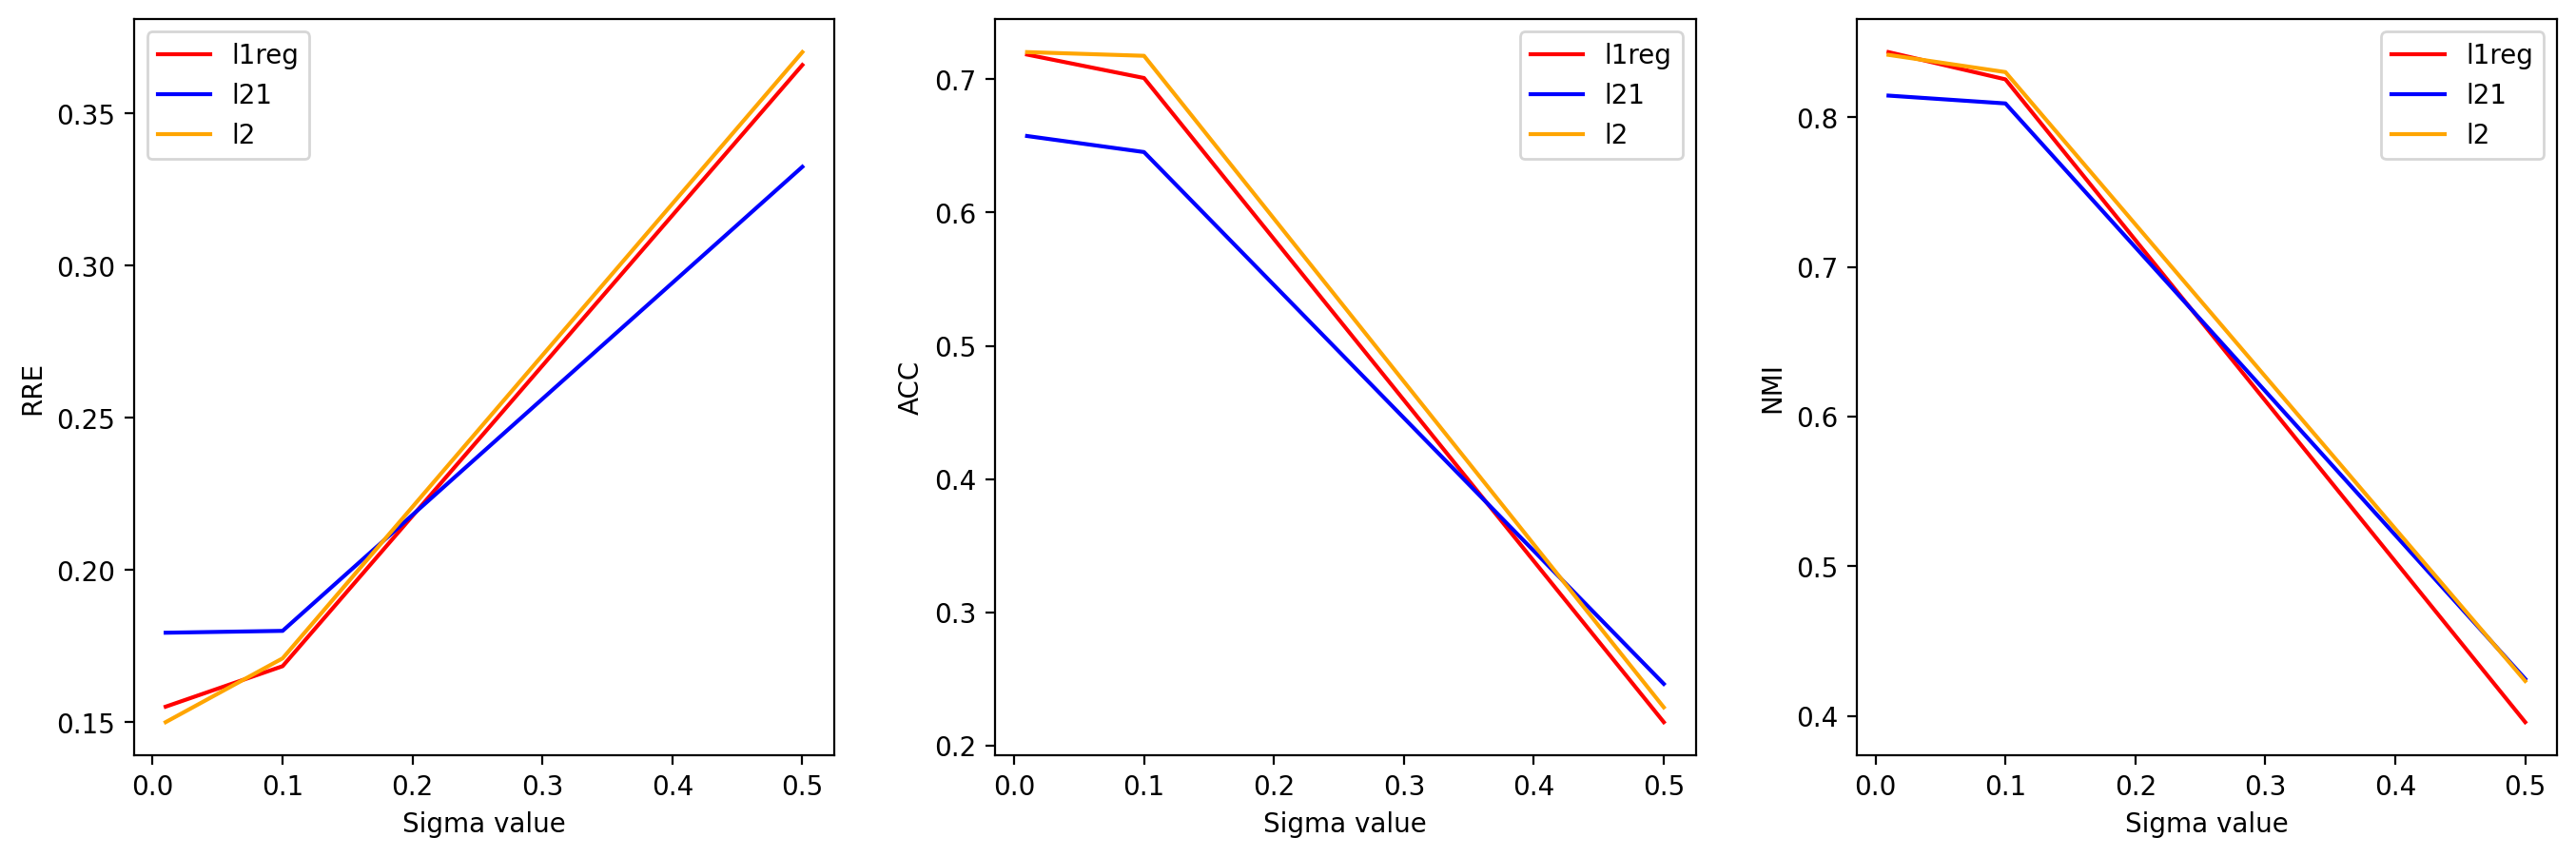

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_sig, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_sig, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.plot(n_sig, [item[2] for item in overall_mean_rre], color="orange", label=alg[2])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Sigma value")

# Plot ACC
ax2.plot(n_sig, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_sig, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.plot(n_sig, [item[2] for item in overall_mean_acc], color="orange", label=alg[2])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Sigma value")

# Plot NMI
ax3.plot(n_sig, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_sig, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.plot(n_sig, [item[2] for item in overall_mean_nmi], color="orange", label=alg[2])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Sigma value")

#### CroppedYaleB

In [ ]:
X, Y = load_data(root='drive/My Drive/CroppedYaleB', reduce=3)

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for sig in n_sig:
  print(f"Sigma value: {sig}")
  print("--------------------------------------------")

  params["sigma"] = sig
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_experiment=2, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Text(0.5, 66.44444444444444, 'Sigma value')

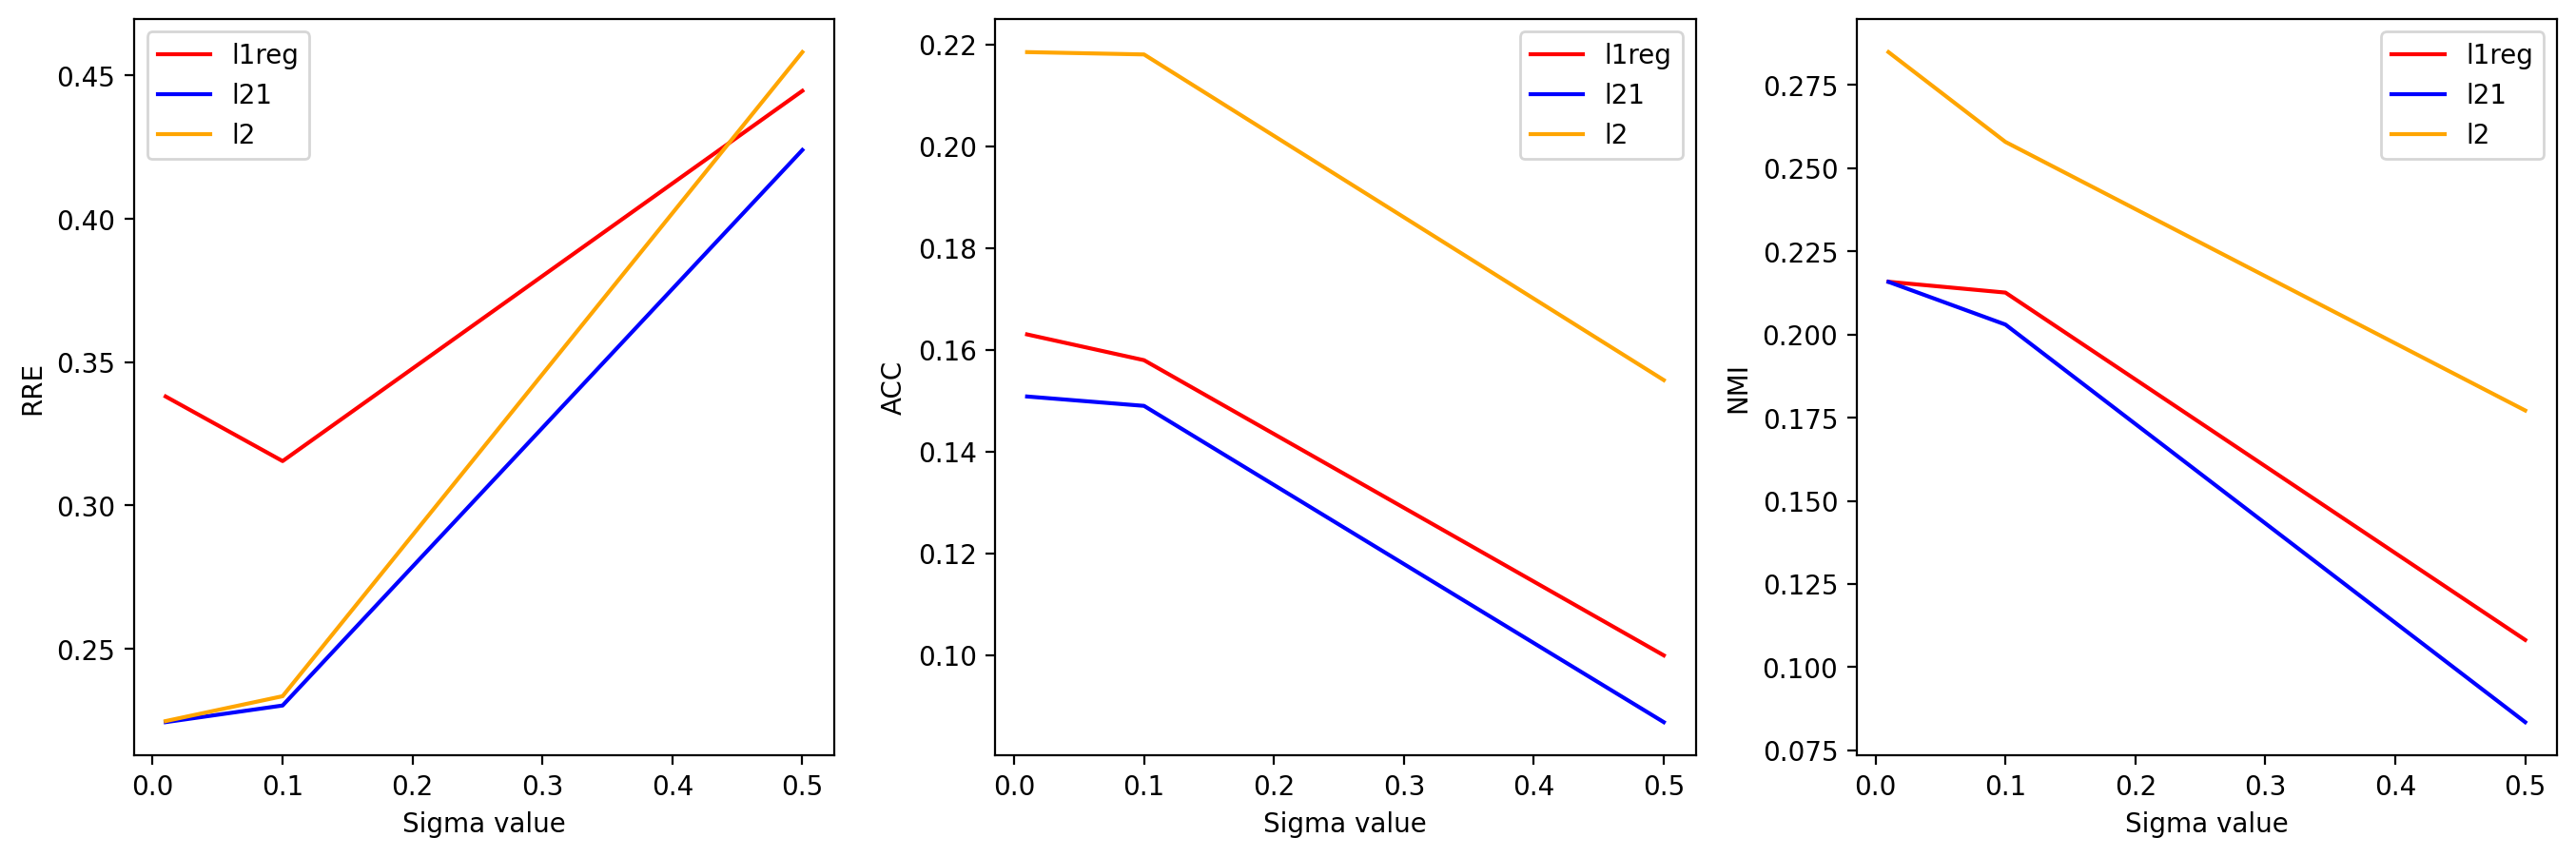

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_sig, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_sig, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.plot(n_sig, [item[2] for item in overall_mean_rre], color="orange", label=alg[2])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Sigma value")

# Plot ACC
ax2.plot(n_sig, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_sig, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.plot(n_sig, [item[2] for item in overall_mean_acc], color="orange", label=alg[2])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Sigma value")

# Plot NMI
ax3.plot(n_sig, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_sig, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.plot(n_sig, [item[2] for item in overall_mean_nmi], color="orange", label=alg[2])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Sigma value")

### 4.3.- Performance Comparison

####Load datasets ORL/CroppedYaleB & Prepare parameters

In [ ]:
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/ORL", reduce=3)

In [ ]:
n_components = 60
n_iters = 300
n_experiments = np.arange(3)
n_repeat = 3
alg=["l1reg", "l21", "l2"]
params = {"p": 0, "s_vs_p": 0, "loc": 0, "scale": 0, "reg_param": 0.04}

####Salt & Pepper Noise Experiments

In [ ]:
type_noise = "salt_pepper"
p=[0.125, 0.188, 0.25]
svp=[0.167, 0.25, 0.333]

#####ORL

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Component: {n_exp}")
  print("--------------------------------------------")
  params["p"]=p[n_exp]
  params["s_vs_p"]=svp[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Component: 0
--------------------------------------------
Parameters: {'p': 0.125, 's_vs_p': 0.167, 'reg_param': 0.04}
Running experiments for: l1reg
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 2.257 - Acc: 0.085 - NMI: 0.087
Iteration: 5 - Error: 0.578 - Acc: 0.071 - NMI: 0.062
Iteration: 10 - Error: 0.499 - Acc: 0.078 - NMI: 0.071
Iteration: 15 - Error: 0.425 - Acc: 0.074 - NMI: 0.066
Iteration: 20 - Error: 0.404 - Acc: 0.081 - NMI: 0.062
Iteration: 25 - Error: 0.387 - Acc: 0.072 - NMI: 0.052
Iteration: 30 - Error: 0.375 - Acc: 0.075 - NMI: 0.054
Iteration: 35 - Error: 0.368 - Acc: 0.069 - NMI: 0.051
Iteration: 40 - Error: 0.363 - Acc: 0.073 - NMI: 0.052
Iteration: 45 - Error: 0.358 - Acc: 0.088 - NMI: 0.082
Iteration: 50 - Error: 0.353 - Acc: 0.099 - NMI: 0.111
Iteration: 55 - Error: 0.35 - Acc: 0.097 - NMI: 0.095
Iteration: 60 - Error: 0.346 - Acc: 0.098 - NMI: 0.114
Iteration: 65 - Error

KeyboardInterrupt: ignored

#####CroppedYaleB

In [ ]:
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/CroppedYaleB", reduce=3)

In [ ]:
n_iters = 100
n_repeat = 2

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Component: {n_exp+1}")
  print("--------------------------------------------")
  params["p"]=p[n_exp]
  params["s_vs_p"]=svp[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_experiment=n_repeat,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Component: 0
--------------------------------------------
Parameters: {'p': 0.125, 's_vs_p': 0.167, 'reg_param': 0.04}
Running experiments for: l1reg
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 2.263 - Acc: 0.081 - NMI: 0.084
Iteration: 5 - Error: 0.584 - Acc: 0.07 - NMI: 0.067
Iteration: 10 - Error: 0.51 - Acc: 0.076 - NMI: 0.071
Iteration: 15 - Error: 0.435 - Acc: 0.077 - NMI: 0.063
Iteration: 20 - Error: 0.415 - Acc: 0.075 - NMI: 0.073
Iteration: 25 - Error: 0.4 - Acc: 0.076 - NMI: 0.061
Iteration: 30 - Error: 0.388 - Acc: 0.073 - NMI: 0.048
Iteration: 35 - Error: 0.379 - Acc: 0.074 - NMI: 0.065
Iteration: 40 - Error: 0.374 - Acc: 0.074 - NMI: 0.067
Iteration: 45 - Error: 0.369 - Acc: 0.09 - NMI: 0.095
Iteration: 50 - Error: 0.364 - Acc: 0.089 - NMI: 0.103
Iteration: 55 - Error: 0.361 - Acc: 0.094 - NMI: 0.122
Iteration: 60 - Error: 0.358 - Acc: 0.102 - NMI: 0.124
Iteration: 65 - Error: 0.

####Laplacian Noise Experiments

In [ ]:
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/ORL", reduce=3)
n_iters = 300
n_repeat = 3

In [ ]:
type_noise = "laplace"
scales = [0.06, 0.09, 0.12]

#####ORL

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Experiment: {n_exp}")
  print("--------------------------------------------")
  params["scale"]=scales[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Experiment: 0
--------------------------------------------
Parameters: {'loc': 0, 'scale': 0.06, 'reg_param': 0.04}
Running experiments for: l1reg
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 1.668 - Acc: 0.197 - NMI: 0.374
Iteration: 5 - Error: 0.289 - Acc: 0.203 - NMI: 0.384
Iteration: 10 - Error: 0.287 - Acc: 0.189 - NMI: 0.381
Iteration: 15 - Error: 0.281 - Acc: 0.228 - NMI: 0.395
Iteration: 20 - Error: 0.27 - Acc: 0.244 - NMI: 0.445
Iteration: 25 - Error: 0.255 - Acc: 0.303 - NMI: 0.505
Iteration: 30 - Error: 0.241 - Acc: 0.383 - NMI: 0.571
Iteration: 35 - Error: 0.228 - Acc: 0.431 - NMI: 0.636
Iteration: 40 - Error: 0.217 - Acc: 0.5 - NMI: 0.68
Iteration: 45 - Error: 0.207 - Acc: 0.55 - NMI: 0.724
Iteration: 50 - Error: 0.199 - Acc: 0.581 - NMI: 0.76
Iteration: 55 - Error: 0.192 - Acc: 0.619 - NMI: 0.785
Iteration: 60 - Error: 0.186 - Acc: 0.631 - NMI: 0.789
Iteration: 65 - Error: 0.182 

#####CroppedYaleB

In [ ]:
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/CroppedYaleB", reduce=3)
n_iters = 100
n_repeat = 2

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Experiment: {n_exp+1}")
  print("--------------------------------------------")
  params["scale"]=scales[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_experiment=n_repeat,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Experiment: 0
--------------------------------------------
Parameters: {'loc': 0, 'scale': 0.06, 'reg_param': 0.04}
Running experiments for: l1reg
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 2.202 - Acc: 0.089 - NMI: 0.089
Iteration: 5 - Error: 0.573 - Acc: 0.071 - NMI: 0.069
Iteration: 10 - Error: 0.474 - Acc: 0.078 - NMI: 0.081
Iteration: 15 - Error: 0.414 - Acc: 0.075 - NMI: 0.076
Iteration: 20 - Error: 0.394 - Acc: 0.079 - NMI: 0.066
Iteration: 25 - Error: 0.378 - Acc: 0.071 - NMI: 0.061
Iteration: 30 - Error: 0.365 - Acc: 0.073 - NMI: 0.064
Iteration: 35 - Error: 0.356 - Acc: 0.078 - NMI: 0.064
Iteration: 40 - Error: 0.349 - Acc: 0.079 - NMI: 0.067
Iteration: 45 - Error: 0.344 - Acc: 0.088 - NMI: 0.084
Iteration: 50 - Error: 0.339 - Acc: 0.095 - NMI: 0.104
Iteration: 55 - Error: 0.334 - Acc: 0.103 - NMI: 0.121
Iteration: 60 - Error: 0.33 - Acc: 0.106 - NMI: 0.137
Iteration: 65 - Error: 0

## Appendix

This section contains some images generated for the report.

In [ ]:
-----------------------------------
Parameters: {'p': 0.3125, 's_vs_p': 0.5555555555555556, 'reg_param': 0.04}
Running experiments for: l1reg

In [ ]:
n_experiments = np.arange(3)
p = np.true_divide(n_experiments,16)
s_vs_p = np.true_divide(n_experiments,12)

In [ ]:
scales = [0, 0.06, 0.09, 0.12, 0.16, 0.19]

In [ ]:
enumerate(scales)

In [ ]:
X, Y = load_data("/content/drive/My Drive/Colab Notebooks/comp5328-assignment-1/data/CroppedYaleB", reduce=3)

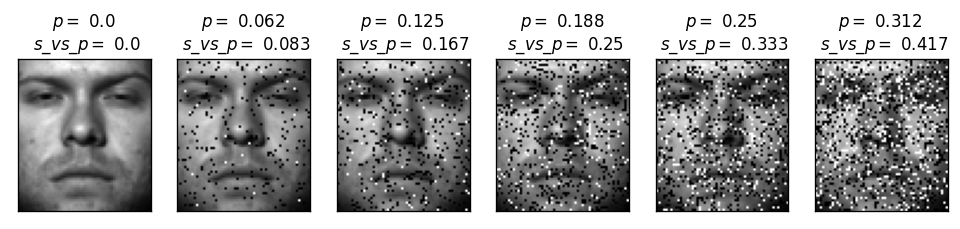

In [ ]:
# SALT AND PEPPER NOISE
# Plot n images
p_range = np.around(p,3) #[0, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1]
s_vs_p_range = np.around(s_vs_p,3) #[0, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 1]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (168, 192)] # ORL

plt.figure(figsize=(10, 6), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, param in enumerate(zip(p_range, s_vs_p_range)):
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    p = param[0]
    s_vs_p = param[1]
    test_img_noise = salt_pepper_noise(X[:, :img_idx], p=p, s_vs_p=s_vs_p)

    test_img_noise = array2img(test_img_noise[:, 0], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$p =$ {p} \n $s\_vs\_p =$ {s_vs_p}', fontsize=10)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

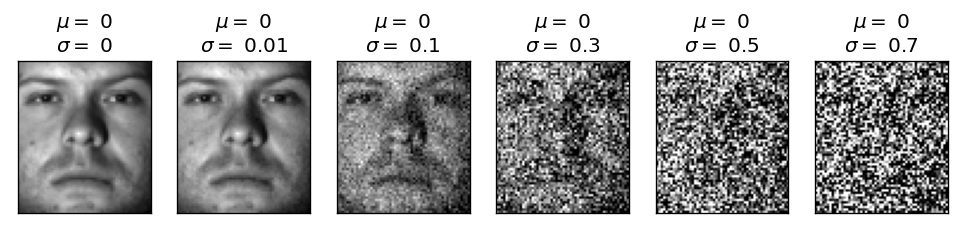

In [ ]:
# GAUSSIAN EXAMPLE
# Plot n images
sigma = [0, 0.01, 0.1, 0.3, 0.5, 0.7]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (168, 192)] # ORL #92, 112

plt.figure(figsize=(10,6), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, s in enumerate(sigma):
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    test_img_noise = gaussian_noise_2d(X, mean=0, sigma=s)


    test_img_noise = array2img(test_img_noise[:, 1], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$\mu =$ 0\n$\sigma =$ {s}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

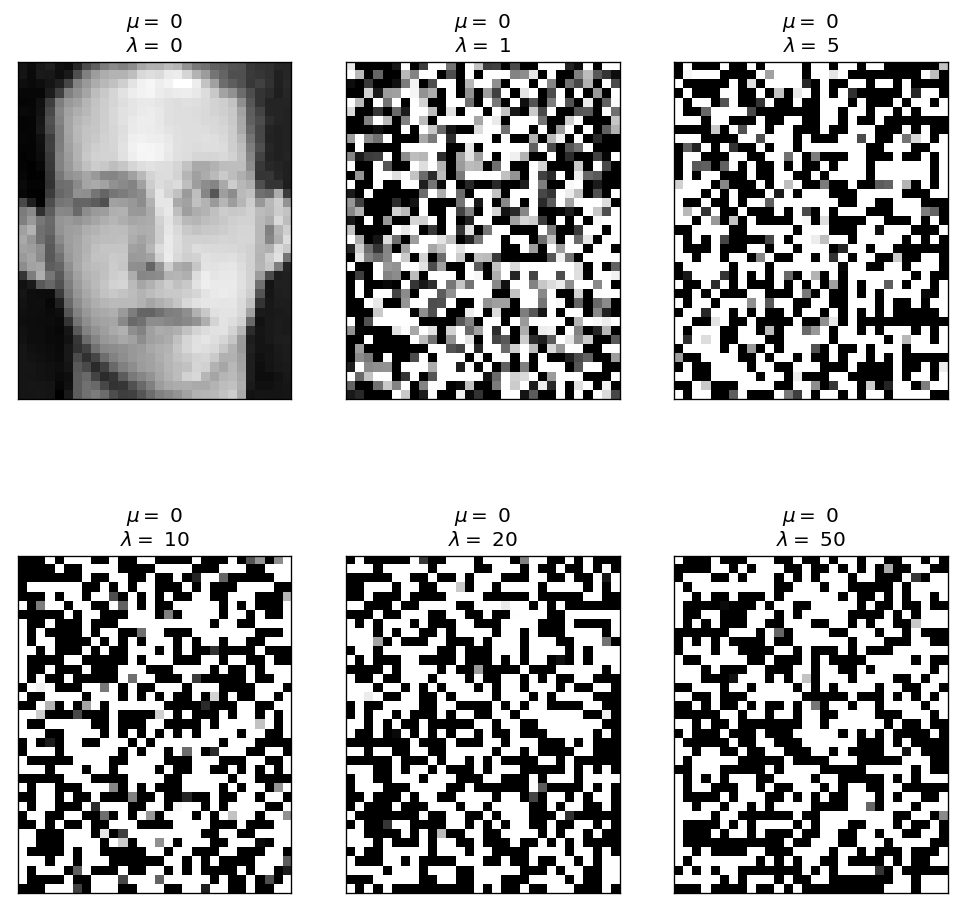

In [ ]:
# LAPLACE EXAMPLE
# Plot n images
sigma = [0, 1, 5, 10, 20, 50]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (92, 112)] # ORL

plt.figure(figsize=(10,10), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, s in enumerate(sigma):
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    test_img_noise = laplace_noise(X, loc=0, scale=s)


    test_img_noise = array2img(test_img_noise[:, 0], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$\mu =$ 0\n$\lambda =$ {s}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

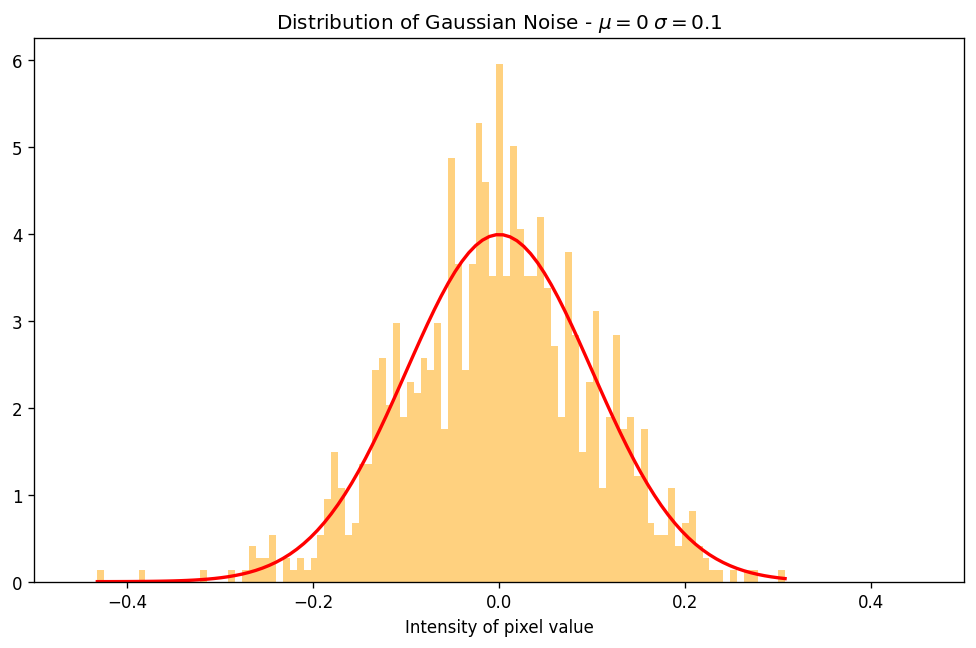

In [ ]:
# GAUSSIAN NOISE
import matplotlib.pyplot as plt
mu = 0
sigma = 0.1
s = np.random.normal(mu, sigma, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlim((-0.5, 0.5))
plt.title("Distribution of Gaussian Noise - $\mu = 0 \; \sigma = 0.1$")
plt.xlabel("Intensity of pixel value")
plt.show()

NameError: ignored

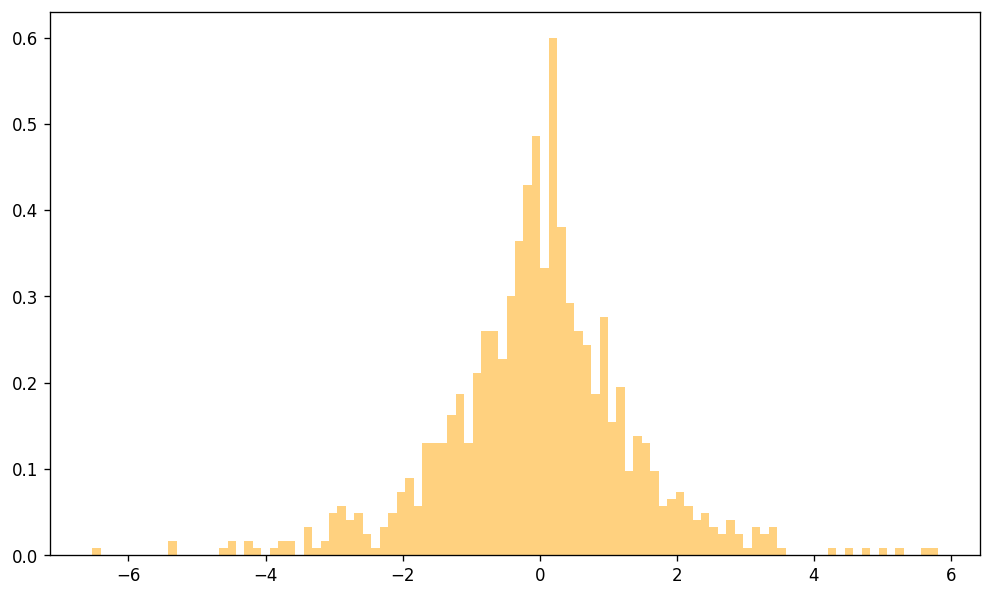

In [ ]:
# LAPLACE NOISE
import matplotlib.pyplot as plt
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)

pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
plt.xlim((-8, 8))
plt.title("Distribution of Laplace Noise")
plt.show()

In [ ]:
# COMBINE BOTH
import matplotlib.pyplot as plt
mu = 0
sigma = 0.1
s_gauss = np.random.normal(mu, sigma, 1000)
loc, scale = 0., 1.
s_laplace = np.random.laplace(loc, scale, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)

# Laplace
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf, color="r", label="Gaussian Noise - $\mu=0$, $\sigma=0.1$")

# Gaussian
g = (1/(scale * np.sqrt(2 * np.pi)) *
     np.exp(-(x - loc)**2 / (2 * scale**2)))
plt.plot(x, g, color="salmon", label="Laplace Noise - $\mu=0$, $\lambda=1$")

plt.xlim((-8, 8))
plt.title("Comparison of Gaussian and Laplace Noise")
plt.xlabel("Intensity of pixel value")
plt.legend()
plt.show()

Text(0.5, 66.44444444444444, 'Test-case No. of Salt & Pepper Noise')

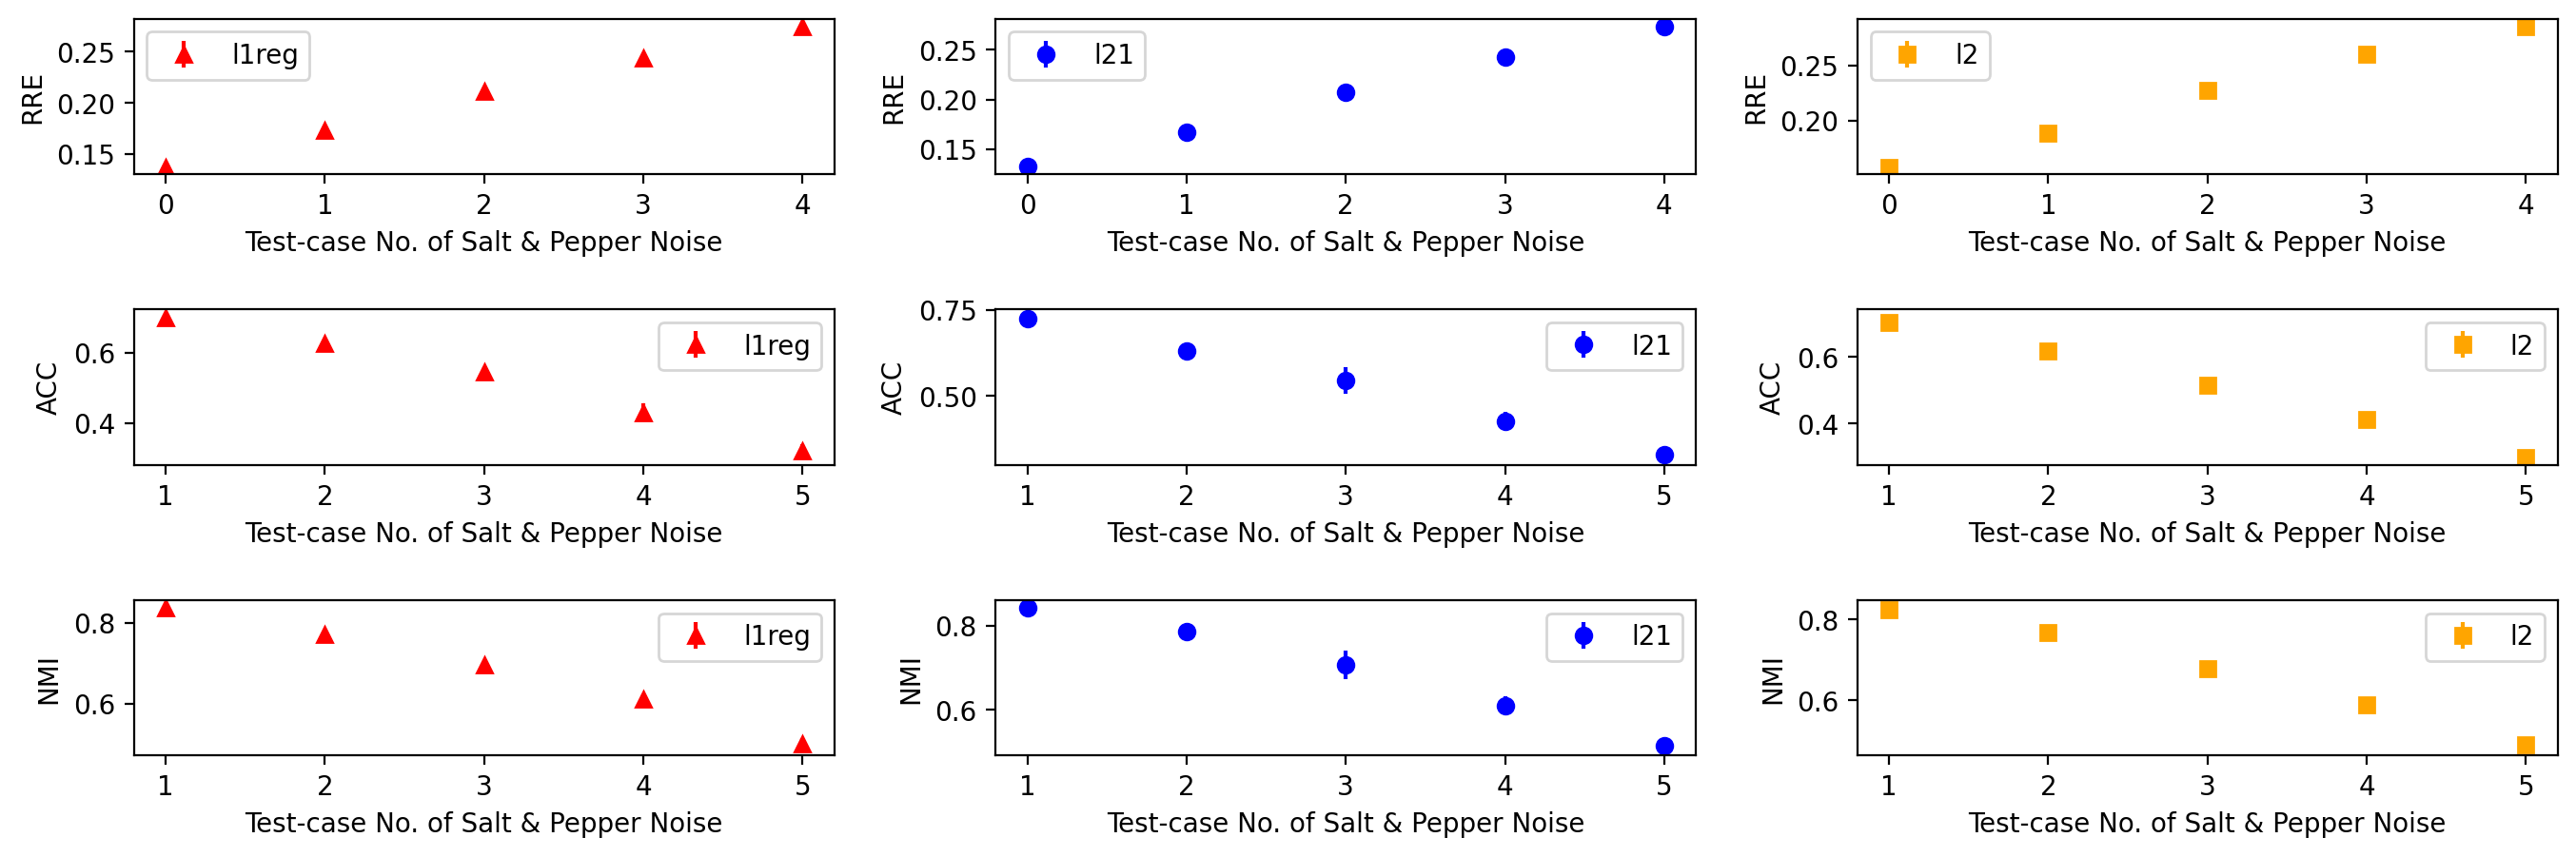

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
e = np.array([1.5, 2.6, 3.7, 4.6, 5.5])

# Display results
fig, ax = plt.subplots(3, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Additional line to fix error
n_components = np.arange(10, 200, 10)
n_components = n_components[:(len(n_components)-5)]

# Plot RRE
ax[0, 0].errorbar(n_experiments[0:5], [item[0] for item in overall_mean_rre[0:5]], [item[0] for item in overall_std_rre[0:5]], 
             linestyle='None', color="red", fmt='^', label=alg[0])
ax[0, 1].errorbar(n_experiments[0:5], [item[1] for item in overall_mean_rre[0:5]], [item[1] for item in overall_std_rre[0:5]], 
             linestyle='None', color="blue", fmt='o', label=alg[1])
ax[0, 2].errorbar(n_experiments[0:5], [item[2] for item in overall_mean_rre[0:5]], [item[2] for item in overall_std_rre[0:5]], 
             linestyle='None', color="orange", fmt='s', label=alg[2])
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 2].legend()
ax[0, 0].set_ylabel("RRE")
ax[0, 1].set_ylabel("RRE")
ax[0, 2].set_ylabel("RRE")
ax[0, 0].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[0, 1].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[0, 2].set_xlabel("Test-case No. of Salt & Pepper Noise")

# Plot ACC
ax[1, 0].errorbar(n_experiments[1:6], [item[0] for item in overall_mean_acc[1:6]], [item[0] for item in overall_std_acc[1:6]], 
             linestyle='None', color="red", fmt='^', label=alg[0])
ax[1, 1].errorbar(n_experiments[1:6], [item[1] for item in overall_mean_acc[1:6]], [item[1] for item in overall_std_acc[1:6]], 
             linestyle='None', color="blue", fmt='o', label=alg[1])
ax[1, 2].errorbar(n_experiments[1:6], [item[2] for item in overall_mean_acc[1:6]], [item[2] for item in overall_std_acc[1:6]], 
             linestyle='None', color="orange", fmt='s', label=alg[2])
ax[1, 0].legend()
ax[1, 1].legend()
ax[1, 2].legend()
ax[1, 0].set_ylabel("ACC")
ax[1, 1].set_ylabel("ACC")
ax[1, 2].set_ylabel("ACC")
ax[1, 0].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[1, 1].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[1, 2].set_xlabel("Test-case No. of Salt & Pepper Noise")

# Plot NMI
ax[2, 0].errorbar(n_experiments[1:6], [item[0] for item in overall_mean_nmi[1:6]], [item[0] for item in overall_std_nmi[1:6]], 
             linestyle='None', color="red", fmt='^', label=alg[0])
ax[2, 1].errorbar(n_experiments[1:6], [item[1] for item in overall_mean_nmi[1:6]], [item[1] for item in overall_std_nmi[1:6]], 
             linestyle='None', color="blue", fmt='o', label=alg[1])
ax[2, 2].errorbar(n_experiments[1:6], [item[2] for item in overall_mean_nmi[1:6]], [item[2] for item in overall_std_nmi[1:6]], 
             linestyle='None', color="orange", fmt='s', label=alg[2])
ax[2, 0].legend()
ax[2, 1].legend()
ax[2, 2].legend()
ax[2, 0].set_ylabel("NMI")
ax[2, 1].set_ylabel("NMI")
ax[2, 2].set_ylabel("NMI")
ax[2, 0].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[2, 1].set_xlabel("Test-case No. of Salt & Pepper Noise")
ax[2, 2].set_xlabel("Test-case No. of Salt & Pepper Noise")